In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack

/Users/isaromobru/Desktop/FakeNews 10.57.24/proyecto_machine_learning_Fake_News/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 10/10 [06:35<00:00, 39.53s/it]
/Users/isaromobru/Desktop/FakeNews 10.57.24/proyecto_machine_learning_Fake_News/.venv/lib/python3.11/site-packages/shap/plots/_beeswarm.py:728: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  pl.xlim((slow, shigh))
/Users/isaromobru/Desktop/FakeNews 10.57.24/proyecto_machine_learning_Fake_News/.venv/lib/python3.11/site-packages/shap/plots/_beeswarm.py:748: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  pl.xlim((slow, shigh))


<Figure size 640x480 with 0 Axes>

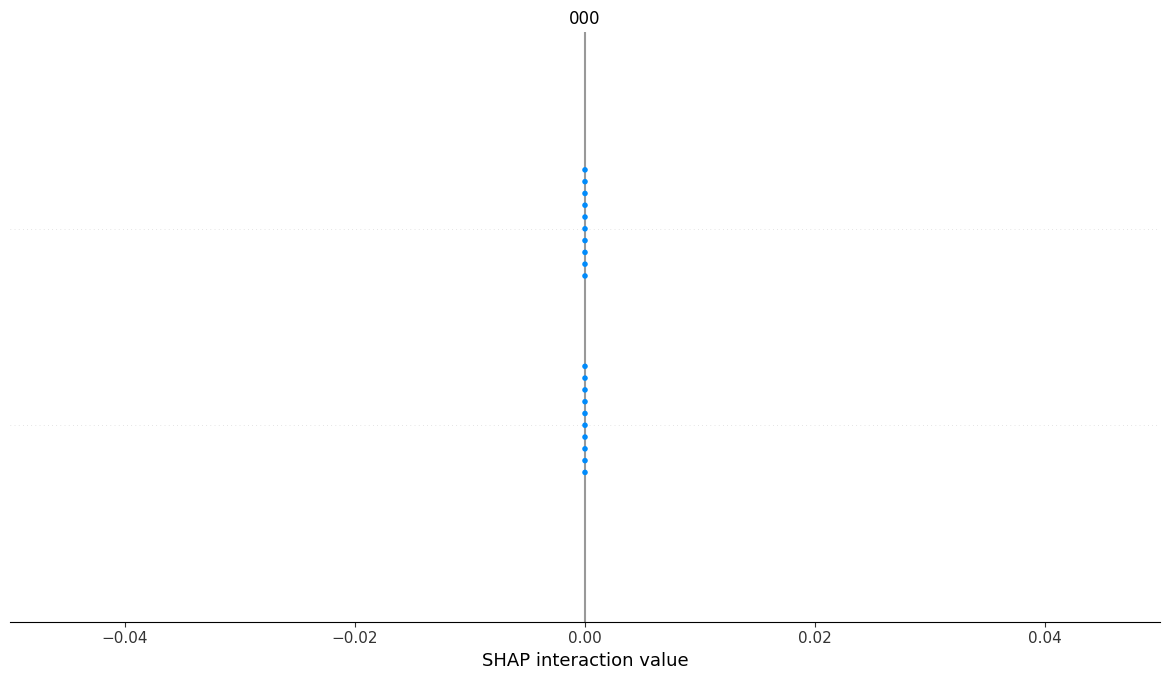

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import shap
from scipy.sparse import hstack, csr_matrix

# 1. Cargar datos
df = pd.read_csv("/Users/isaromobru/Desktop/FakeNews 10.57.24/proyecto_machine_learning_Fake_News/notebooks/processedstopword2.csv")
# Se asume que el CSV tiene las columnas: 'text', 'title' y 'subject'
if df['subject'].dtype == 'object':
    le = LabelEncoder()
    df['subject'] = le.fit_transform(df['subject'])

# 2. Vectorizar 'text' y 'title'
vectorizer_text = TfidfVectorizer(max_features=1000)
vectorizer_title = TfidfVectorizer(max_features=1000)
X_text = vectorizer_text.fit_transform(df['text'])
X_title = vectorizer_title.fit_transform(df['title'])

# 3. Procesar 'subject'
subject_feature = csr_matrix(df['subject'].values.reshape(-1, 1))

# 4. Combinar las tres fuentes en una matriz dispersa
X_combined = hstack([subject_feature, X_title, X_text])
feature_names_subject = ["subject"]
feature_names_title = list(vectorizer_title.get_feature_names_out())
feature_names_text = list(vectorizer_text.get_feature_names_out())
combined_feature_names = feature_names_subject + feature_names_title + feature_names_text

assert X_combined.shape[1] == len(combined_feature_names), "El número de nombres de features no coincide."

# 5. Entrenar el modelo
model = XGBClassifier()
model.fit(X_combined, df['label'])

# 6. Definir una función de predicción que acepte datos densos
def model_predict(X):
    # X vendrá como un array denso
    return model.predict_proba(X)

# 7. Seleccionar un pequeño subconjunto de fondo y convertirlo a denso
X_background = X_combined[0:100].toarray()

# 8. Crear el explainer usando KernelExplainer
explainer = shap.KernelExplainer(model_predict, X_background, feature_names=combined_feature_names)

# 9. Seleccionar algunas muestras para explicar (convertir a denso)
X_test = X_combined[100:110].toarray()

# 10. Calcular los SHAP values
shap_values = explainer.shap_values(X_test)

# 11. Visualizar el summary plot
shap.summary_plot(shap_values, X_test, feature_names=combined_feature_names)
